In [1]:
# Importando bibliotecas

import os
import wfdb
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, cohen_kappa_score

In [2]:
# Definindo funções

# --------------------------------------------
## Plotar sinal de ECG com os picos detectados

def plot_detected_peaks(t, ecg_signal, detected_peaks):
    # Plotar os sinais original e filtrado com os picos QRS detectados
    plt.figure(figsize=(12, 8))
    plt.plot(t, ecg_signal, label='Sinal original', alpha=0.7)
    plt.scatter(t[detected_peaks], ecg_signal[detected_peaks], color='red', marker='o', label='Picos QRS')
    plt.title('Sinal de ECG com Picos R Detectados')
    plt.vlines(t[detected_peaks], *plt.ylim(), label="Picos", color=".2", alpha=0.3, ls="--")
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

# --------------------------------------------
## Indices de qualidade

def compute_iSQI(detected_peaks, total_beats):
    return len(detected_peaks) / total_beats * 100

def compute_fSQI(ecg_signal, sampling_rate=1000):
    fn = 0.5 * sampling_rate  # Frequência de Nyquist
    power_5_20Hz = np.sum(np.square(ecg_signal[(5 <= fn) & (fn <= 20)]))
    power_0_fnHz = np.sum(np.square(ecg_signal[fn <= 0.5 * sampling_rate]))
    return power_5_20Hz / power_0_fnHz

def compute_sSQI(ecg_signal):
    return skew(ecg_signal)

def compute_kSQI(ecg_signal):
    return kurtosis(ecg_signal)

def compute_pSQI(ecg_signal, epsilon=1.0):
    dxm_dt = np.gradient(ecg_signal)
    flat_line_percentage = np.sum(np.abs(dxm_dt) < epsilon) / len(ecg_signal) * 100
    return flat_line_percentage

def get_quality_indexes(peaks, t, ecg_signal):
    # Calcular índices de qualidade
    iSQI_value = compute_iSQI(peaks, len(t))
    fSQI_value = compute_fSQI(ecg_signal)
    sSQI_value = compute_sSQI(ecg_signal)
    kSQI_value = compute_kSQI(ecg_signal)
    pSQI_value = compute_pSQI(ecg_signal)
    return [iSQI_value, fSQI_value, sSQI_value, kSQI_value, pSQI_value]

In [3]:
# Generate binary classification analysis
def classification_metrics_binary(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    perc_tn, perc_fp, perc_fn, perc_tp = list(map(lambda x:x/len(y_true)*100, [tn, fp, fn, tp]))
    sensitivity = tp/(tp+fn)
    false_positive_rate = fp/(tn+fp)
    precision = tp/(tp+fp)
    specificity = tn/(tn+fp)
    accuracy = (tp+tn)/(tp+fp+tn+fn)
    f1_score = 2*precision*sensitivity/(sensitivity+precision)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc_value = auc(fpr, tpr)
    kappa = cohen_kappa_score(y_true, y_pred)
    return {"tn":tn, "fp":fp, "fn":fn, "tp":tp, "perc_tn":perc_tn, "perc_fp":perc_fp, 
            "perc_fn":perc_fn, "perc_tp":perc_tp, "sensitivity":sensitivity, 
            "tpr":sensitivity, "recall":sensitivity, "fpr":false_positive_rate, 
            "precision":precision, "ppv":precision, "specificity":specificity, 
            "tnr":specificity,"f1_score":f1_score, "auc":auc_value, "kappa":kappa, 
            "accuracy":accuracy}

# Plot Confusion Matrix
def plot_confusion(y_true, y_pred):
    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    class_name = ['Ruim', 'Bom']
    cm = pd.DataFrame(cm, index=class_name, columns=class_name)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    # Salva a figura como .eps
    plt.savefig('confusion_matrix_FAxNORMAL_preprocessed.eps', format='eps')

    # Salva a figura como .png com 300 DPI
    plt.savefig('confusion_matrix_FAxNORMAL_preprocessed.png', format='png', dpi=300)

    plt.show()


In [4]:
# VISUALIZANDO RESULTADOS

def show_results(idx):
    paciente = df_ecg_cinc2011[idx]['Paciente']
    classe = df_ecg_cinc2011[idx]['Classe']
    features = df_ecg_cinc2011[idx]['Features']
    ecg = df_ecg_cinc2011[idx]['Sinais']
    picos = df_ecg_cinc2011[idx]['Picos']

    print(f'FILENAME: {paciente}')
    print(f'CLASSE: {classe}')
    print(f'FEATURES: {features}')

    plot_detected_peaks(t, ecg, picos)

In [5]:
# Diretório que contém os arquivos .hea e .dat
diretorio = 'C:/Users/estela.ribeiro/JupyterNotebooks/ECGcodes/set-a/'

In [6]:
# Gerando o dataset

# Lista para armazenar os sinais, nomes de arquivo e classes
df_ecg_cinc2011 = []

# Lê os nomes dos pacientes da classe 'positiva' a partir do arquivo .txt
with open(diretorio + 'RECORDS-acceptable', 'r') as file_positivo:
    boa_qualidade = [line.strip() for line in file_positivo]

# Lê os nomes dos pacientes da classe 'negativa' a partir do arquivo .txt
with open(diretorio + 'RECORDS-unacceptable', 'r') as file_negativo:
    ma_qualidade = [line.strip() for line in file_negativo]

# Itera sobre todos os arquivos no diretório
for arquivo in os.listdir(diretorio):
    if arquivo.endswith('.hea'):
        # Extrai o nome do arquivo sem a extensão
        nome_base = os.path.splitext(arquivo)[0]

        # Carrega as informações do cabeçalho (.hea)
        record = wfdb.rdheader(os.path.join(diretorio, nome_base))

        # Carrega os dados do sinal (.dat)
        signals, _ = wfdb.rdsamp(os.path.join(diretorio, nome_base))
        
        # Como vou usar apenas a DII, seleciono apenas essa derivação
        ecg_signal = signals[:,1]

        # Determina a classe do paciente
        if nome_base in boa_qualidade:
            classe = 1 # bom
        elif nome_base in ma_qualidade:
            classe = 0 # ruim
        else:
            classe = np.nan
        
        # Identifica os picos nos sinais de ECG
        sampling_rate = record.fs
        duration = 10 # segundos
        t = np.arange(0, duration, 1/sampling_rate)
        peaks, _ = find_peaks(ecg_signal, height = 0.2, distance = sampling_rate/2)
        
        # Gera os indices de qualidade
        indices = get_quality_indexes(peaks, t, ecg_signal)
        
        #plot_detected_peaks(t, ecg_signal, peaks) # Deixar comentado essa linha para não gerar os plots

        # Adiciona os sinais, informações adicionais e a classe à lista
        df_ecg_cinc2011.append({'Paciente': nome_base, 'Sinais': ecg_signal, 'Frequencia de Amostragem': record.fs, 
                                'Classe': classe, 'Picos': peaks, 'Features': indices})

C:\Users\ESTELA~1.RIB\AppData\Local\Temp/ipykernel_11844/2564668317.py:28: RuntimeWarning: invalid value encountered in double_scalars
  return power_5_20Hz / power_0_fnHz


In [7]:
df_ecg_cinc2011 = pd.DataFrame(df_ecg_cinc2011)

# Seleciona apenas as colunas relevantes (Features e Classe)
df_ecg = df_ecg_cinc2011[['Features', 'Classe']]

df_ecg.head()

,Features,Classe
0,"[0.0, 0.0, 0.0, -3.0, 100.0]",0.0
1,"[0.2, 0.0, -0.46612093186253545, 19.3928051755...",1.0
2,"[0.16, 0.0, -2.1746740930593185, 9.44945315641...",0.0
3,"[0.3, 0.0, -0.6684783077838481, 2.535005784455...",0.0
4,"[0.2, 0.0, 4.419841197862508, 25.0690525928515...",1.0


In [8]:
df = pd.DataFrame(df_ecg['Features'].tolist(), columns=['iSQI', 'fSQI', 'sSQI', 'kSQI', 'pSQI'])
df['Classe'] = df_ecg['Classe']

df.head()

,iSQI,fSQI,sSQI,kSQI,pSQI,Classe
0,0.00,0.0,0.000000,-3.000000,100.0,0.0
1,0.20,0.0,-0.466121,19.392805,100.0,1.0
2,0.16,0.0,-2.174674,9.449453,100.0,0.0
3,0.30,0.0,-0.668478,2.535006,100.0,0.0
4,0.20,0.0,4.419841,25.069053,100.0,1.0


In [9]:
print(f'NaN? : {pd.isna(df).sum()}')

NaN? : iSQI       0
fSQI      12
sSQI       0
kSQI       0
pSQI       0
Classe     2
dtype: int64


In [10]:
df = df.dropna()

In [11]:
print(f'NaN? : {pd.isna(df).sum()}')

NaN? : iSQI      0
fSQI      0
sSQI      0
kSQI      0
pSQI      0
Classe    0
dtype: int64


In [12]:
# Separa as Features e a Classe
X = df[['iSQI', 'fSQI', 'sSQI', 'kSQI', 'pSQI']]
y = df['Classe']

In [13]:
# Divide o conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializa o modelo Random Forest
modelo_rf = RandomForestClassifier(random_state=42)

# Treina o modelo
modelo_rf.fit(X_train, y_train)

# Faz predições no conjunto de teste
y_pred = modelo_rf.predict(X_test)

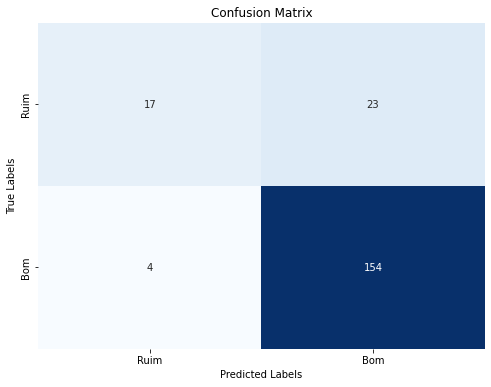

{'tn': 17, 'fp': 23, 'fn': 4, 'tp': 154, 'perc_tn': 8.585858585858585, 'perc_fp': 11.616161616161616, 'perc_fn': 2.0202020202020203, 'perc_tp': 77.77777777777779, 'sensitivity': 0.9746835443037974, 'tpr': 0.9746835443037974, 'recall': 0.9746835443037974, 'fpr': 0.575, 'precision': 0.8700564971751412, 'ppv': 0.8700564971751412, 'specificity': 0.425, 'tnr': 0.425, 'f1_score': 0.9194029850746267, 'auc': 0.6998417721518988, 'kappa': 0.485862665897288, 'accuracy': 0.8636363636363636}


In [14]:
y_true = y_test

# Results
plot_confusion(y_true, y_pred)
results = classification_metrics_binary(y_true, y_pred)
print(results)


In [15]:
results

{'tn': 17,
 'fp': 23,
 'fn': 4,
 'tp': 154,
 'perc_tn': 8.585858585858585,
 'perc_fp': 11.616161616161616,
 'perc_fn': 2.0202020202020203,
 'perc_tp': 77.77777777777779,
 'sensitivity': 0.9746835443037974,
 'tpr': 0.9746835443037974,
 'recall': 0.9746835443037974,
 'fpr': 0.575,
 'precision': 0.8700564971751412,
 'ppv': 0.8700564971751412,
 'specificity': 0.425,
 'tnr': 0.425,
 'f1_score': 0.9194029850746267,
 'auc': 0.6998417721518988,
 'kappa': 0.485862665897288,
 'accuracy': 0.8636363636363636}

In [27]:
# Feature importance
importance = modelo_rf.feature_importances_
sorted_indices = np.argsort(importance)[::-1]
sorted_importance = importance[sorted_indices]
sorted_features = X.columns[sorted_indices]

# Print list of features and importance
for i, v in enumerate(sorted_importance):
    print('Feature: %s, Score: %f' % (sorted_features[i], v))

Feature: kSQI, Score: 0.432942
Feature: sSQI, Score: 0.291665
Feature: iSQI, Score: 0.184362
Feature: pSQI, Score: 0.091031
Feature: fSQI, Score: 0.000000


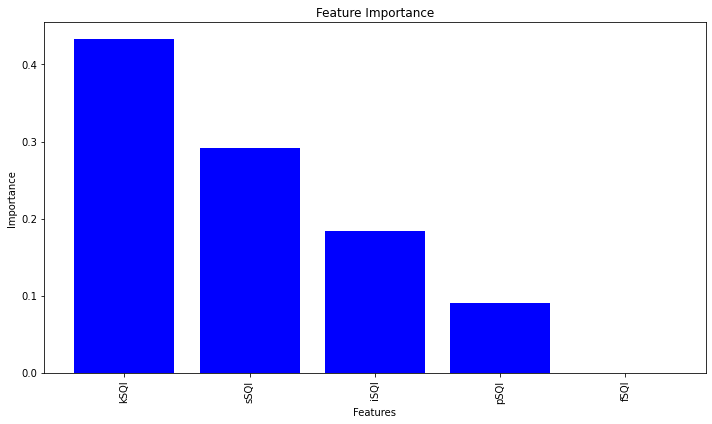

In [26]:
# Define colors for positive and negative values
colors = ['red' if imp < 0 else 'blue' for imp in sorted_importance]

# Plot the feature importance with colored bars
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importance)), sorted_importance, color=colors, tick_label=sorted_features)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [20]:
sorted_features

Index(['kSQI', 'sSQI', 'iSQI', 'pSQI', 'fSQI'], dtype='object')

In [24]:
sorted_importance

array([0.43294237, 0.29166534, 0.18436166, 0.09103063, 0.        ])

In [22]:
sorted_indices

array([3, 2, 0, 4, 1], dtype=int64)

In [23]:
importance

array([0.18436166, 0.        , 0.29166534, 0.43294237, 0.09103063])

In [21]:
X.columns

Index(['iSQI', 'fSQI', 'sSQI', 'kSQI', 'pSQI'], dtype='object')

In [25]:
X.columns[sorted_indices]

Index(['kSQI', 'sSQI', 'iSQI', 'pSQI', 'fSQI'], dtype='object')